## 3DCNN model evalutaion

In [1]:
import pandas as pd
import joblib as jbl
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

## Sampling -> Magnification -> Optical Flow

In [2]:
data_casme = jbl.load("../data/casme_mag_of.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_mag_of.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
labels = pd.read_csv("../data/labels.csv", index_col="Unnamed: 0")
display(labels.head(5))

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


,AU17,AU6,AU10,AU14,AU5,AU4,AU15,AU7,AU20,AU25,AU9,AU24,AU1,AU2,AU12,emotion
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,happiness
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,others
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,others
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,others
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,others


In [3]:
labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
NUM_EMOTIONS = len(labels["emotion"].unique())
NUM_AUS = len(labels.columns[1:])
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
le = LabelEncoder()
le.fit(labels["emotion"])
emotions = le.transform(labels["emotion"])
aus = labels[labels.columns[:-1]].to_numpy()
DATA_SIZE = concatted.shape[0]

We need to alter the class weights for emotions

In [4]:
emotion_counts = labels["emotion"].value_counts()
display(emotion_counts)
display(labels[labels.columns[:-1]].sum())
inverse_freq = 1 / emotion_counts.values
inverse_freq = np.ceil(20 * (inverse_freq / np.max(inverse_freq)))
codes = le.transform(emotion_counts.keys())
arg_sorted = np.argsort(codes)
class_weights = inverse_freq[arg_sorted]

emotion
others                 130
negative               127
disgust                 64
surprise                54
positive                34
repression              33
happiness               32
surprise+positive       14
surprise+negative        8
positive+repression      8
sadness                  7
negative+repression      7
surprise+repression      3
fear                     2
Name: count, dtype: int64

AU17     36
AU6      38
AU10     18
AU14     31
AU5      10
AU4     232
AU15     22
AU7     128
AU20      3
AU25      2
AU9      14
AU24     11
AU1      72
AU2      76
AU12     87
dtype: int64

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)

In [ ]:
class_weights = tf.cast(tf.constant(class_weights), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    weight = tf.gather(class_weights, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weight

def basic_block(inputs, filters, stride=(1,1,1)):

    x = tf.keras.layers.Conv3D(filters, (3,3,3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters, (1,3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    shortcut = inputs
    if stride != (1,1,1) or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv3D(filters, (3,3,3), strides=stride, padding="same")(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def make_blocks(inputs, filters, blocks, stride=(1,1,1)):
    x = basic_block(inputs, filters, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filters, stride=(1,1,1))
    return x

def video_encoder(input_shape=(8,224,224,3), pooling='avg'):
    video_in = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv3D(32, (3,7,7), strides=(1,2,2), padding="same")(video_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D((1,3,3), strides=(1,2,2), padding="same")(x)

    # spatiotemporal compression  begins
    x = make_blocks(x, 32, blocks=1, stride=2)
    x = make_blocks(x, 64, blocks=1, stride=2)
    x = make_blocks(x, 128, blocks=1, stride=2)
    x = make_blocks(x, 256, blocks=1, stride = (2, 3, 3)) 
    x = tf.keras.layers.Dropout(0.2)(x)

    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling3D()(x)
    else:
        x = tf.keras.layers.Flatten()(x)

    model = tf.keras.Model(video_in, x)
    return model

def build_3d_cnn(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=256, dropout_f = 0.2):

    T, H, W, C = input_shape
    video_in = tf.keras.layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)
    encoder = video_encoder(input_shape=(T, H,W,C), pooling=None)
    dropout = tf.keras.layers.Dropout(dropout_f)(encoder(video_in))
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu")(dropout)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dense)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dense)

    model = tf.keras.Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="2D_BiLSTM") # au_logits]
    return model

Model: "2D_BiLSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 7, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 model (Functional)             (None, 2304)         3182560     ['video_in[0][0]']               
                                                                                                  
 dropout_1 (Dropout)            (None, 2304)         0           ['model[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 256)          590080      ['dropout_1[0][0]']      

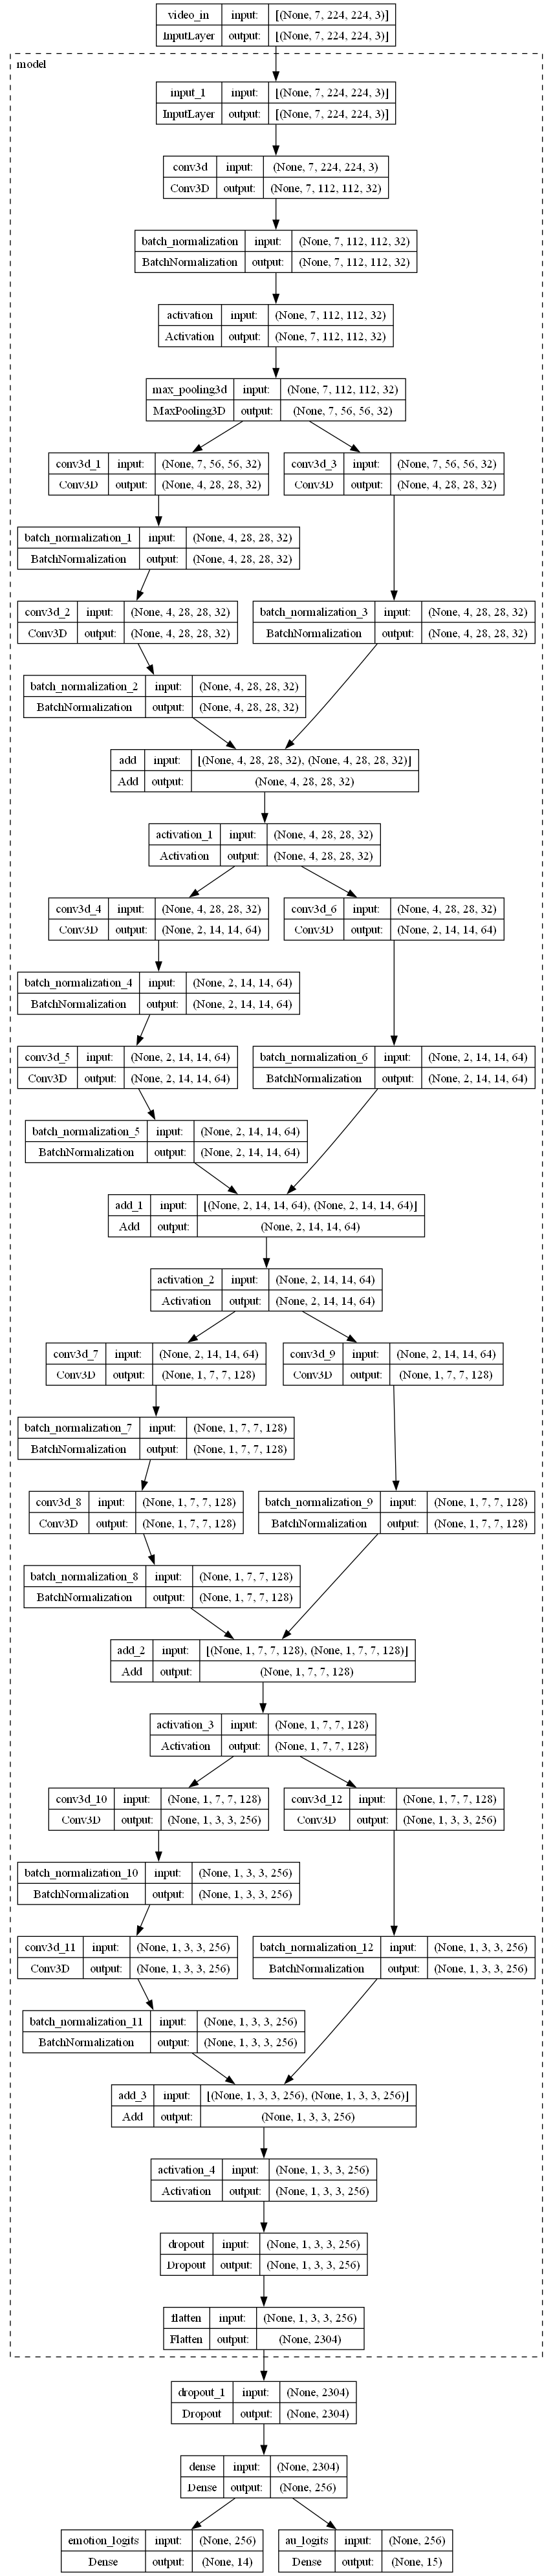

In [7]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=True)

### Using Focal Loss due to sparsity of AU vectors

In [8]:
EPOCHS = 25
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma = 2) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)

Epoch 1/25
313/313 [==============================] - 28s 47ms/step - loss: 5.7454 - emotion_logits_loss: 5.5558 - au_logits_loss: 0.0948 - emotion_logits_sparse_categorical_accuracy: 0.1597 - au_logits_auc: 0.5421 - val_loss: 4.1570 - val_emotion_logits_loss: 4.0673 - val_au_logits_loss: 0.0448 - val_emotion_logits_sparse_categorical_accuracy: 0.2524 - val_au_logits_auc: 0.5281
Epoch 2/25
313/313 [==============================] - 12s 39ms/step - loss: 3.4941 - emotion_logits_loss: 3.3894 - au_logits_loss: 0.0523 - emotion_logits_sparse_categorical_accuracy: 0.4058 - au_logits_auc: 0.5364 - val_loss: 3.2421 - val_emotion_logits_loss: 3.1499 - val_au_logits_loss: 0.0461 - val_emotion_logits_sparse_categorical_accuracy: 0.3143 - val_au_logits_auc: 0.4799
Epoch 3/25
313/313 [==============================] - 12s 39ms/step - loss: 2.0296 - emotion_logits_loss: 1.9334 - au_logits_loss: 0.0481 - emotion_logits_sparse_categorical_accuracy: 0.5463 - au_logits_auc: 0.5792 - val_loss: 2.0644 - 

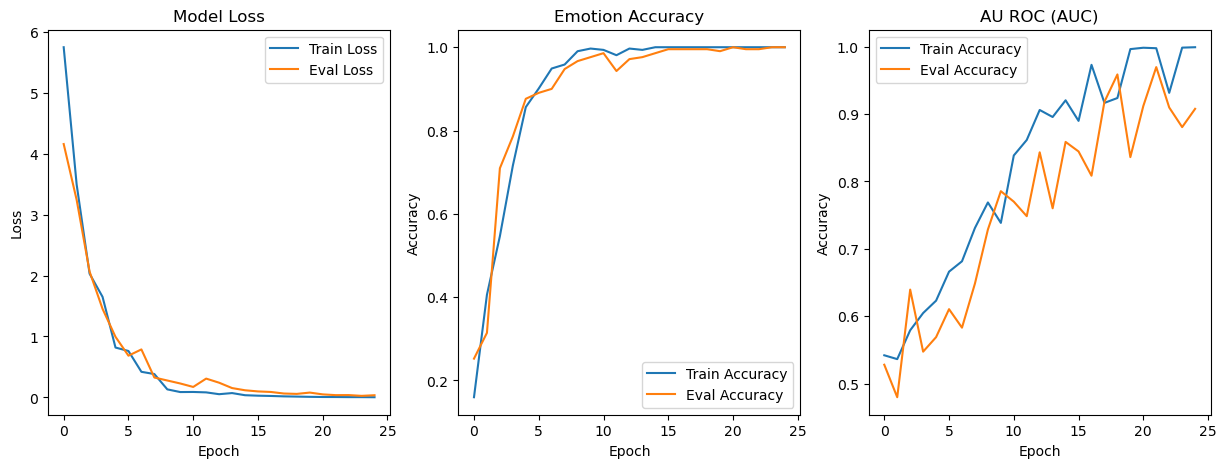

              precision    recall  f1-score   support

        AU17       1.00      0.71      0.83        17
         AU6       1.00      0.50      0.67        14
        AU10       1.00      0.88      0.93         8
        AU14       1.00      0.54      0.70        13
         AU5       0.00      0.00      0.00         6
         AU4       1.00      0.94      0.97        96
        AU15       1.00      0.17      0.29        12
         AU7       1.00      0.67      0.81        46
        AU20       0.00      0.00      0.00         0
        AU25       0.00      0.00      0.00         1
         AU9       1.00      0.20      0.33         5
        AU24       1.00      0.33      0.50         3
         AU1       0.94      0.94      0.94        31
         AU2       1.00      0.68      0.81        38
        AU12       1.00      0.61      0.75        33

   micro avg       0.99      0.72      0.84       323
   macro avg       0.80      0.48      0.57       323
weighted avg       0.97   

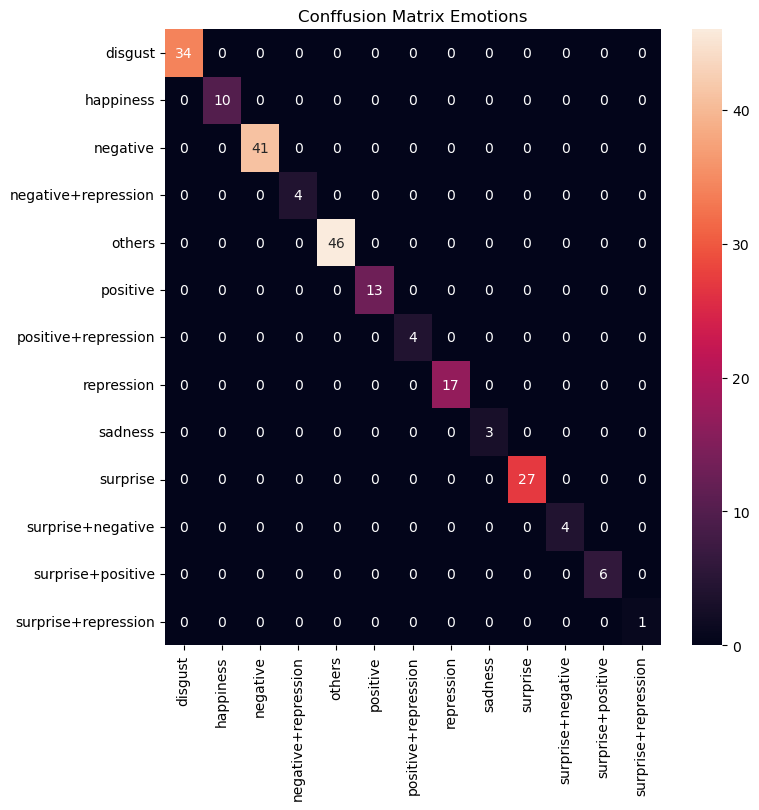

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def results(history, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    emotion_train_accuracy = history.history['emotion_logits_sparse_categorical_accuracy']
    emotion_val_accuracy =  history.history['val_emotion_logits_sparse_categorical_accuracy']
    au_train_accuracy =  history.history['au_logits_auc'+ prefix]
    au_val_accuracy =  history.history['val_au_logits_auc'+ prefix]

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(EPOCHS)
        plt.subplot(1, 3, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(emotion_train_accuracy, emotion_val_accuracy, "Accuracy", 2, "Emotion Accuracy")
    plot_history(au_train_accuracy, au_val_accuracy, "Accuracy", 3, "AU ROC (AUC)")
    plt.show()

results(history, "")
def eval_model(validation_data, model):
    true_emotions = []
    true_AUs = []
    pred_emotions = []
    pred_AUs = []
    count = 0
    for video, (emotion, au_vector) in validation_data:
        count += 1
        true_emotions.append(emotion.numpy().squeeze())
        true_AUs.append(au_vector.numpy().squeeze())
        pred = model.predict(video, verbose = 0)
        pred_emotions.append(np.argmax(pred[0]))
        pred_AUs.append((pred[1] > 0.5).astype(np.int32).squeeze())
    cr_aus = classification_report(true_AUs, pred_AUs, target_names = labels.columns[:-1], zero_division=0,)
    target_names_emotions = np.unique(true_emotions)
    target_names_emotions = le.inverse_transform(target_names_emotions)
    cr_emotions = classification_report(true_emotions, pred_emotions, target_names=target_names_emotions)
    cm_emotions = confusion_matrix(true_emotions, pred_emotions)
    print(cr_aus)
    print(cr_emotions)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm_emotions, annot=True, fmt= "d", xticklabels=target_names_emotions, yticklabels=target_names_emotions)
    plt.title("Conffusion Matrix Emotions")
    plt.show()

eval_model(validation, model)

## Sample -> Optical Flow

In [10]:
data_casme = jbl.load("../data/casme_optical_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [11]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #target AU binary vectors are way too sparse, so this loss compensates this
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)

Epoch 1/25
313/313 [==============================] - 17s 44ms/step - loss: 5.1579 - emotion_logits_loss: 4.9871 - au_logits_loss: 0.0854 - emotion_logits_sparse_categorical_accuracy: 0.1949 - au_logits_auc_1: 0.5046 - val_loss: 3.9450 - val_emotion_logits_loss: 3.8482 - val_au_logits_loss: 0.0484 - val_emotion_logits_sparse_categorical_accuracy: 0.3381 - val_au_logits_auc_1: 0.5084
Epoch 2/25
313/313 [==============================] - 11s 37ms/step - loss: 2.8938 - emotion_logits_loss: 2.7938 - au_logits_loss: 0.0500 - emotion_logits_sparse_categorical_accuracy: 0.5016 - au_logits_auc_1: 0.5415 - val_loss: 3.9752 - val_emotion_logits_loss: 3.8316 - val_au_logits_loss: 0.0718 - val_emotion_logits_sparse_categorical_accuracy: 0.3905 - val_au_logits_auc_1: 0.4844
Epoch 3/25
313/313 [==============================] - 12s 38ms/step - loss: 1.7961 - emotion_logits_loss: 1.6989 - au_logits_loss: 0.0486 - emotion_logits_sparse_categorical_accuracy: 0.6454 - au_logits_auc_1: 0.5867 - val_loss:

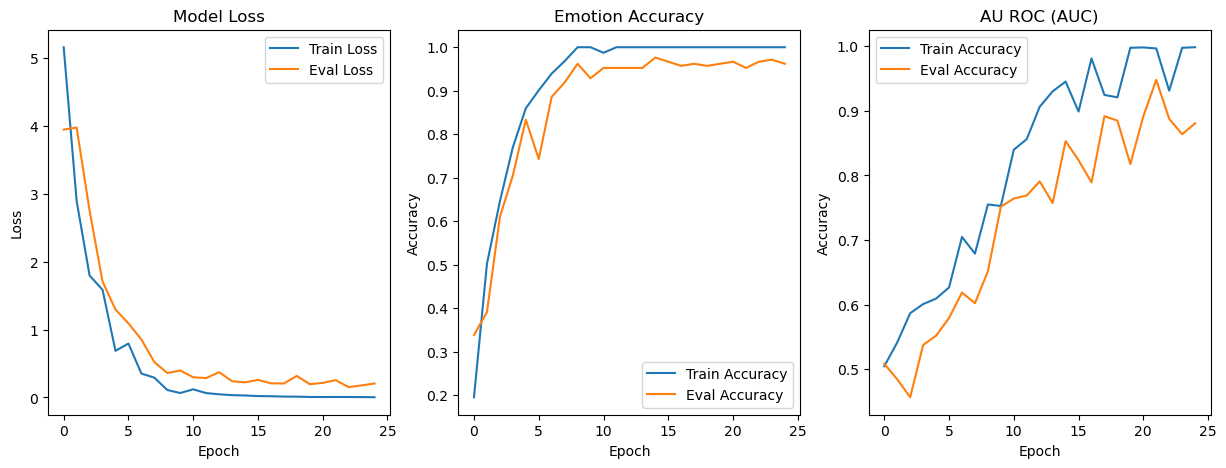

              precision    recall  f1-score   support

        AU17       1.00      0.65      0.79        17
         AU6       1.00      0.29      0.44        14
        AU10       1.00      0.50      0.67         8
        AU14       0.80      0.31      0.44        13
         AU5       1.00      0.17      0.29         6
         AU4       1.00      0.79      0.88        96
        AU15       1.00      0.83      0.91        12
         AU7       1.00      0.59      0.74        46
        AU20       0.00      0.00      0.00         0
        AU25       0.00      0.00      0.00         1
         AU9       1.00      0.60      0.75         5
        AU24       0.00      0.00      0.00         3
         AU1       1.00      0.77      0.87        31
         AU2       1.00      0.79      0.88        38
        AU12       1.00      0.88      0.94        33

   micro avg       1.00      0.69      0.82       323
   macro avg       0.79      0.48      0.57       323
weighted avg       0.98   

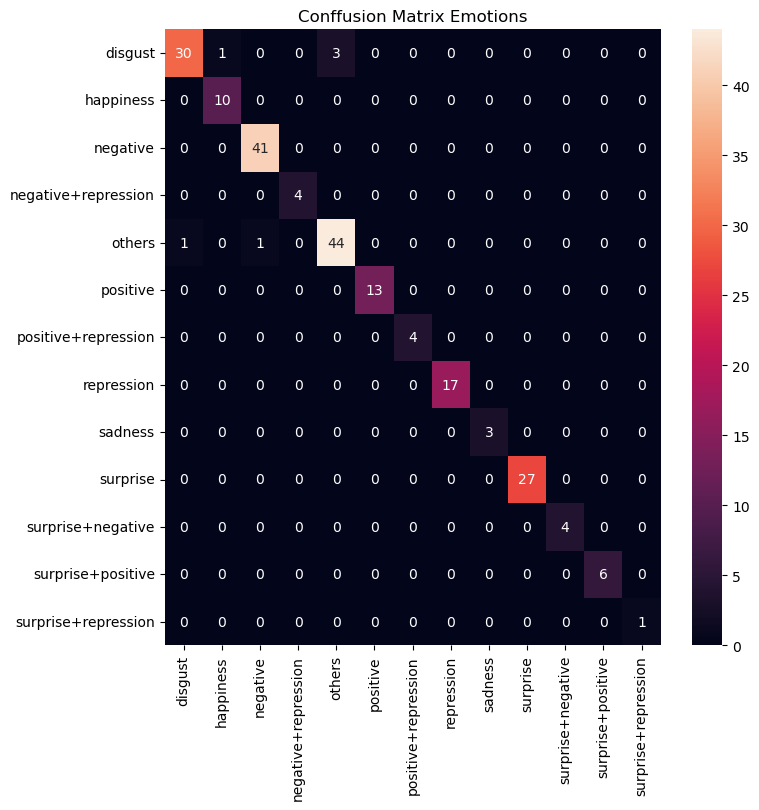

In [12]:
results(history, prefix = "_1")
eval_model(validation, model)

## Magnification -> Sample

In [13]:
data_casme = jbl.load("../data/casme_magnify_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_magnify_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)


Epoch 1/25
313/313 [==============================] - 15s 38ms/step - loss: 5.5136 - emotion_logits_loss: 5.3329 - au_logits_loss: 0.0903 - emotion_logits_sparse_categorical_accuracy: 0.1885 - au_logits_auc_2: 0.4944 - val_loss: 4.1135 - val_emotion_logits_loss: 3.9967 - val_au_logits_loss: 0.0584 - val_emotion_logits_sparse_categorical_accuracy: 0.2524 - val_au_logits_auc_2: 0.5238
Epoch 2/25
313/313 [==============================] - 10s 33ms/step - loss: 4.6567 - emotion_logits_loss: 4.5486 - au_logits_loss: 0.0540 - emotion_logits_sparse_categorical_accuracy: 0.3131 - au_logits_auc_2: 0.5118 - val_loss: 4.7359 - val_emotion_logits_loss: 4.6362 - val_au_logits_loss: 0.0498 - val_emotion_logits_sparse_categorical_accuracy: 0.1762 - val_au_logits_auc_2: 0.4128
Epoch 3/25
313/313 [==============================] - 11s 34ms/step - loss: 3.2435 - emotion_logits_loss: 3.1484 - au_logits_loss: 0.0476 - emotion_logits_sparse_categorical_accuracy: 0.3642 - au_logits_auc_2: 0.5132 - val_loss:

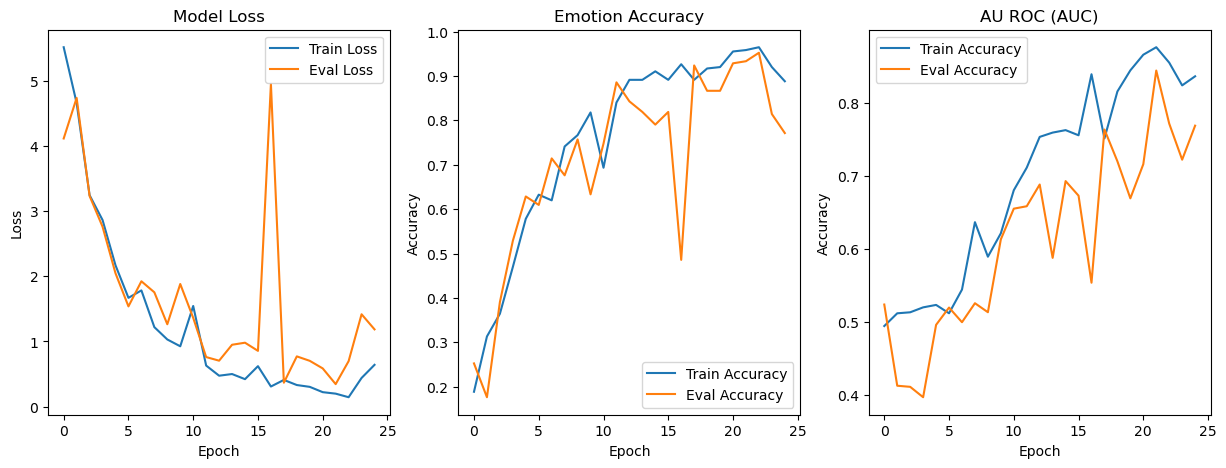

              precision    recall  f1-score   support

        AU17       1.00      0.12      0.21        17
         AU6       0.33      0.14      0.20        14
        AU10       0.00      0.00      0.00         8
        AU14       1.00      0.15      0.27        13
         AU5       0.00      0.00      0.00         6
         AU4       0.95      0.66      0.78        96
        AU15       0.80      0.33      0.47        12
         AU7       0.56      0.39      0.46        46
        AU20       0.00      0.00      0.00         0
        AU25       0.00      0.00      0.00         1
         AU9       1.00      0.20      0.33         5
        AU24       0.00      0.00      0.00         3
         AU1       0.76      0.81      0.78        31
         AU2       1.00      0.16      0.27        38
        AU12       0.81      0.52      0.63        33

   micro avg       0.80      0.43      0.56       323
   macro avg       0.55      0.23      0.29       323
weighted avg       0.79   

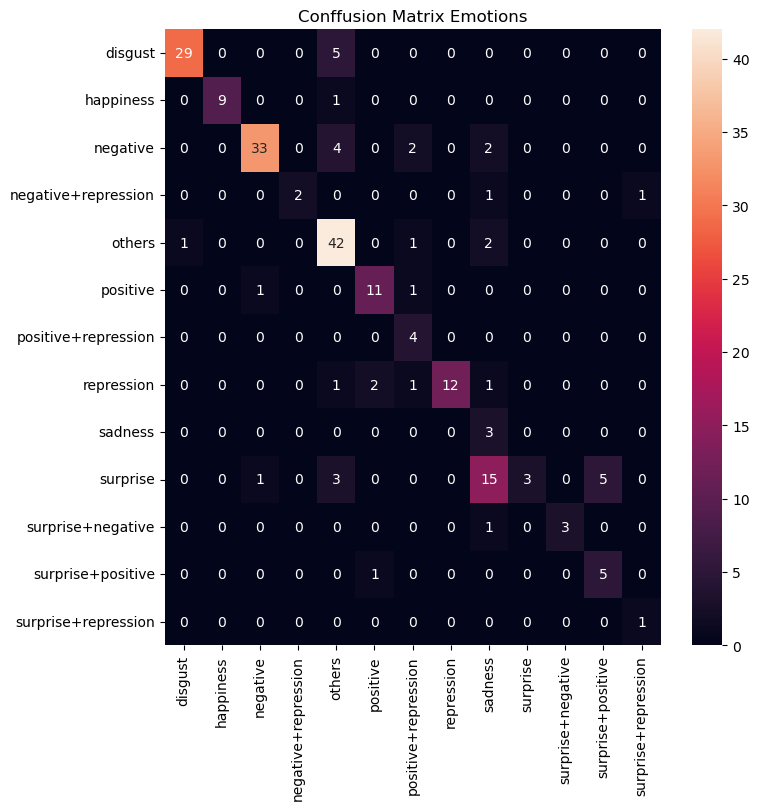

In [14]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)
results(history, prefix = "_2")
eval_model(validation, model)

## Early fusion of Optical flow + LBP

LBPs were computed after magnification and sampling, Optical flow after directly after sampling.

In [15]:
of_casme = jbl.load("../data/casme_optical_only.pkl")
print(of_casme.shape)
of_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(of_4dme.shape)
lbp_casme = jbl.load("../data/casme_magnified_lbps.pkl")
print(lbp_casme.shape)
lbp_4dme = jbl.load("../data/4dme_magnified_lbps.pkl")
print(lbp_4dme.shape)
data_casme = np.concatenate([of_casme, lbp_casme[:, :-1,..., np.newaxis]], axis=-1)
data_4dme = np.concatenate([of_4dme, lbp_4dme[:, :-1,..., np.newaxis]], axis=-1)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 7, 224, 224, 4)


In [16]:
del data_casme
del data_4dme
del of_4dme 
del of_casme
del lbp_casme 
del lbp_4dme

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)

Epoch 1/25
313/313 [==============================] - 19s 51ms/step - loss: 5.3611 - emotion_logits_loss: 5.1766 - au_logits_loss: 0.0923 - emotion_logits_sparse_categorical_accuracy: 0.1853 - au_logits_auc_3: 0.5099 - val_loss: 4.0908 - val_emotion_logits_loss: 3.9901 - val_au_logits_loss: 0.0504 - val_emotion_logits_sparse_categorical_accuracy: 0.1476 - val_au_logits_auc_3: 0.4801
Epoch 2/25
313/313 [==============================] - 13s 40ms/step - loss: 3.0859 - emotion_logits_loss: 2.9877 - au_logits_loss: 0.0491 - emotion_logits_sparse_categorical_accuracy: 0.5048 - au_logits_auc_3: 0.5105 - val_loss: 5.9181 - val_emotion_logits_loss: 5.7544 - val_au_logits_loss: 0.0819 - val_emotion_logits_sparse_categorical_accuracy: 0.2429 - val_au_logits_auc_3: 0.4793
Epoch 3/25
313/313 [==============================] - 13s 40ms/step - loss: 1.9617 - emotion_logits_loss: 1.8691 - au_logits_loss: 0.0463 - emotion_logits_sparse_categorical_accuracy: 0.6102 - au_logits_auc_3: 0.4859 - val_loss:

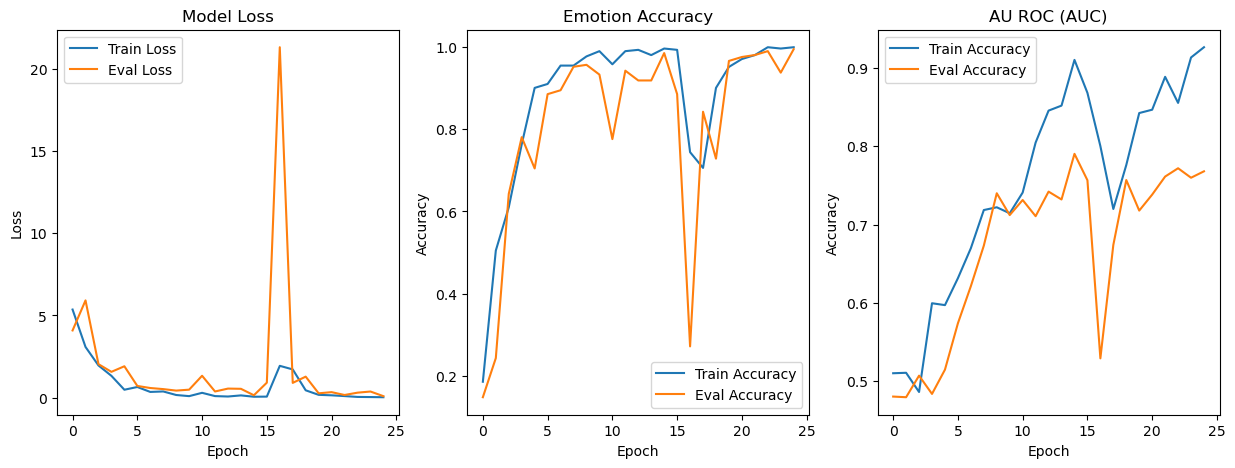

              precision    recall  f1-score   support

        AU17       0.90      0.53      0.67        17
         AU6       0.67      0.14      0.24        14
        AU10       0.57      0.50      0.53         8
        AU14       0.67      0.15      0.25        13
         AU5       0.00      0.00      0.00         6
         AU4       0.98      0.66      0.79        96
        AU15       1.00      0.33      0.50        12
         AU7       0.90      0.39      0.55        46
        AU20       0.00      0.00      0.00         0
        AU25       0.00      0.00      0.00         1
         AU9       0.00      0.00      0.00         5
        AU24       0.00      0.00      0.00         3
         AU1       1.00      0.68      0.81        31
         AU2       0.92      0.61      0.73        38
        AU12       0.80      0.48      0.60        33

   micro avg       0.91      0.50      0.65       323
   macro avg       0.56      0.30      0.38       323
weighted avg       0.86   

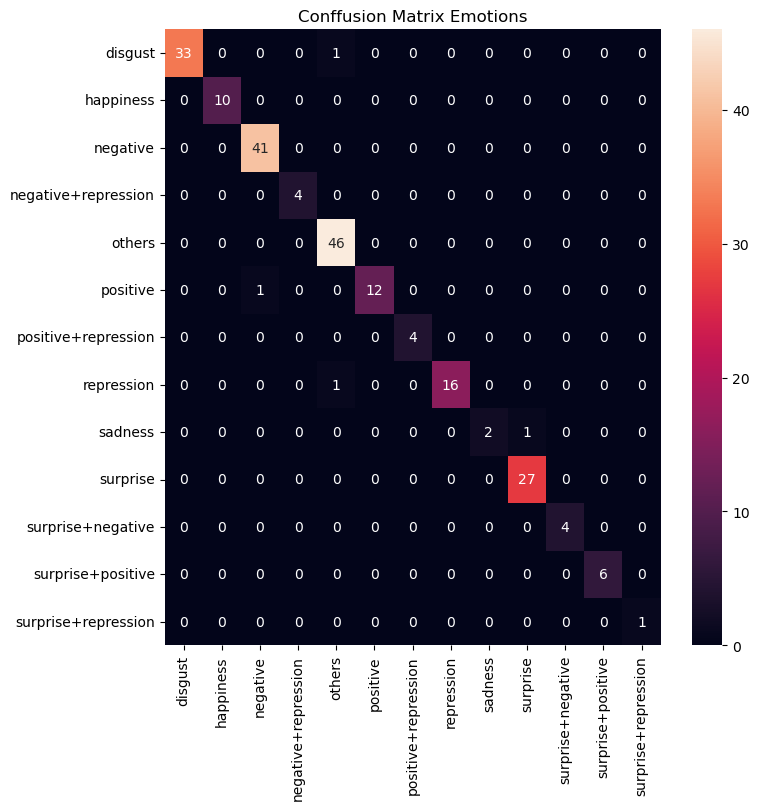

In [18]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)
results(history, prefix = "_3")
eval_model(validation, model)

## Magnification -> Sample -> 3DFFT

In [19]:
data_casme = jbl.load("../data/casme_regional_spatiotemporal_features.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_regional_spatiotemporal_features.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.6)).prefetch(tf.data.AUTOTUNE)

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)
(523, 8, 224, 224)


In [20]:
def basic_block(inputs, filter_num, stride=1):
    x = tf.keras.layers.Conv3D(filters=filter_num, kernel_size=(1,3,3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters=filter_num, kernel_size=(1,3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if filter_num != inputs.shape[-1] or stride != 1:
        shortcut = tf.keras.layers.Conv3D(filters=filter_num, kernel_size=(1,3,3), strides=stride, padding="same")(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x


def encoder(input_shape=None, pooling="avg"):
    video_in = tf.keras.layers.Input(shape=input_shape)
    
    # initial temporal+spatial compression
    x = tf.keras.layers.Conv3D(64, (8,8,8), strides=(1,8,8), padding="valid")(video_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D((1,2,2), padding="valid")(x) 
    
    # residual stacks with small temporal kernel
    x = make_blocks(x, 64, blocks=1, stride=1)   
    x = make_blocks(x, 128, blocks=1, stride=(1,2,2))  
    x = make_blocks(x, 256, blocks=2, stride=(1,2,2))  
    
    if pooling == "avg":
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
    elif pooling == "max":
        x = tf.keras.layers.GlobalMaxPooling3D()(x)
    else:
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    return tf.keras.Model(video_in, x)

def build_3d_cnn(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=256, dropout_f = 0.2):

    T, H, W, C = input_shape
    transform_in = tf.keras.layers.Input(shape=input_shape, name="video_in") 
    enc = encoder(input_shape=(T, H,W,C), pooling="max")
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu",)(enc(transform_in))
    dropout = tf.keras.layers.Dropout(dropout_f)(dense)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dropout)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dropout)

    model = tf.keras.Model(inputs=transform_in, outputs=[emotion_logits, au_logits], name="3D_CNN_3DFFT_INPUT")
    return model

Model: "3D_CNN_3DFFT_INPUT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 8, 224, 224  0           []                               
                                , 1)]                                                             
                                                                                                  
 model_4 (Functional)           (None, 256)          3361088     ['video_in[0][0]']               
                                                                                                  
 dense_4 (Dense)                (None, 256)          65792       ['model_4[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 256)          0           ['dense_4[0][0]'

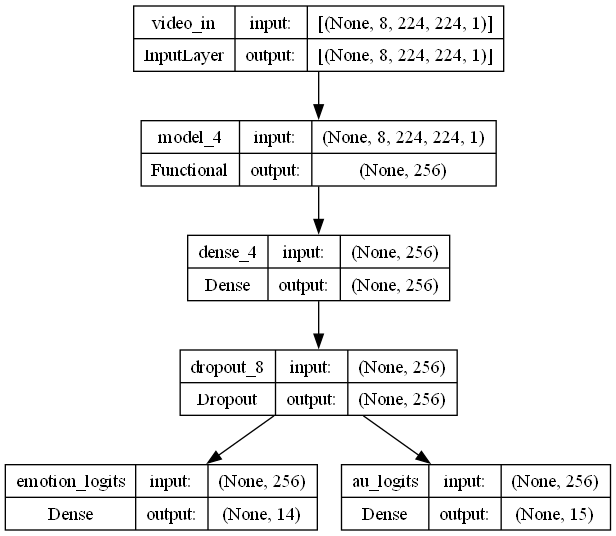

In [21]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.summary()
display(tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=False))

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)

Epoch 1/25
313/313 [==============================] - 15s 34ms/step - loss: 6.6902 - emotion_logits_loss: 6.3201 - au_logits_loss: 0.1851 - emotion_logits_sparse_categorical_accuracy: 0.1246 - au_logits_auc_4: 0.5145 - val_loss: 4.5934 - val_emotion_logits_loss: 4.4621 - val_au_logits_loss: 0.0657 - val_emotion_logits_sparse_categorical_accuracy: 0.1238 - val_au_logits_auc_4: 0.4214
Epoch 2/25
313/313 [==============================] - 9s 29ms/step - loss: 5.7938 - emotion_logits_loss: 5.6521 - au_logits_loss: 0.0708 - emotion_logits_sparse_categorical_accuracy: 0.1885 - au_logits_auc_4: 0.4314 - val_loss: 4.5997 - val_emotion_logits_loss: 4.5247 - val_au_logits_loss: 0.0375 - val_emotion_logits_sparse_categorical_accuracy: 0.0762 - val_au_logits_auc_4: 0.4734
Epoch 3/25
313/313 [==============================] - 9s 29ms/step - loss: 3.6919 - emotion_logits_loss: 3.5784 - au_logits_loss: 0.0567 - emotion_logits_sparse_categorical_accuracy: 0.2812 - au_logits_auc_4: 0.4811 - val_loss: 3

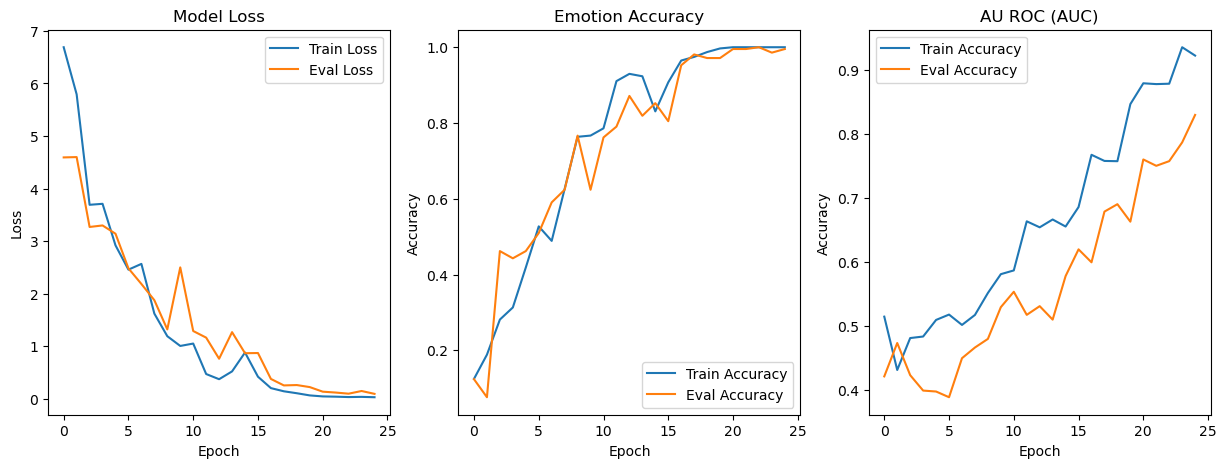

              precision    recall  f1-score   support

        AU17       1.00      0.24      0.38        17
         AU6       0.00      0.00      0.00        14
        AU10       1.00      0.25      0.40         8
        AU14       0.00      0.00      0.00        13
         AU5       0.00      0.00      0.00         6
         AU4       0.99      0.72      0.83        96
        AU15       0.00      0.00      0.00        12
         AU7       0.96      0.54      0.69        46
        AU20       0.00      0.00      0.00         0
        AU25       0.00      0.00      0.00         1
         AU9       0.00      0.00      0.00         5
        AU24       1.00      0.33      0.50         3
         AU1       0.90      0.29      0.44        31
         AU2       0.96      0.68      0.80        38
        AU12       0.93      0.42      0.58        33

   micro avg       0.97      0.46      0.63       323
   macro avg       0.52      0.23      0.31       323
weighted avg       0.81   

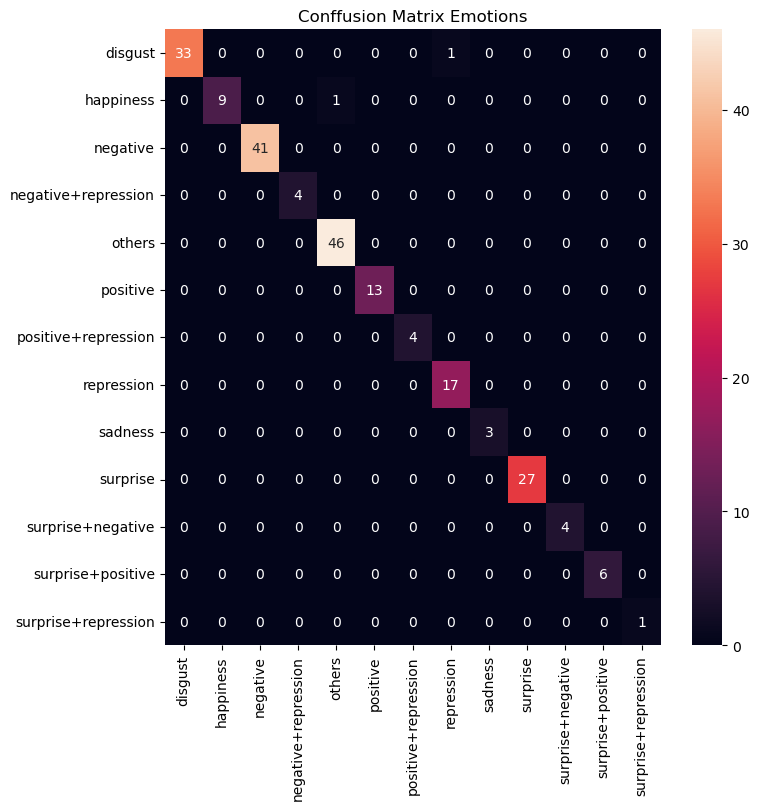

In [23]:
results(history, prefix = "_4")
eval_model(validation, model)